In [1]:
import os
os.chdir("..")

In [2]:
# import the required libraries
from pump_controller import SilicoPumpController, visualize_rgb, visualize_candidates
import matplotlib.pyplot as plt
import numpy as np

# Trying out the SilicoPumpController

### Setup

In [3]:
# Start by creating a SilicoPumpController with noise std = 3
silicobot = SilicoPumpController(noise_std=3)

In [4]:
# Create target for SilicoBot
silicobot.change_target([0.1, 0.2, 0.3, 0.4])

Silico target changed to [131.8076199  153.20490862  73.63182   ]. Created by [0.1, 0.2, 0.3, 0.4].


array([131.8076199 , 153.20490862,  73.63182   ])

In [5]:
# Get the target RGB color and target color mixture
print(silicobot.target_color)

# Get the target RGB mixture
print(silicobot.target_mixture)

[131.8076199  153.20490862  73.63182   ]
[0.1, 0.2, 0.3, 0.4]


### Start Mixing

[131.77924351 127.802604    67.32582199]


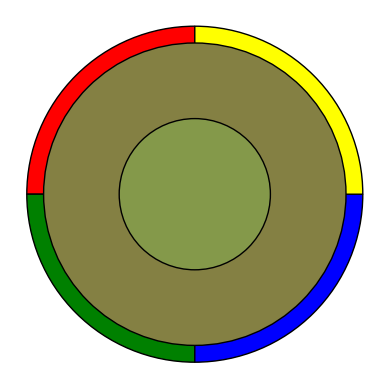

In [6]:
# Start by setting a mixture
color_mixture = [0.25, 0.25, 0.25, 0.25]

# Now mix the color
rgb_measurement = silicobot.mix_color(color_mixture)
print(rgb_measurement)

visualize_rgb(mixture = color_mixture, rgb = rgb_measurement, pump_controller=silicobot)

In [7]:
# Difference between mixed and target colors:
def color_difference(mixed_color, target_color):
    # Calculate the sum of root mean squared differences between mixed color and target color
    rmse = np.sqrt(np.mean((mixed_color - target_color)**2, axis=-1))
    return np.sum(rmse)

In [8]:
difference = color_difference(rgb_measurement, silicobot.target_color)
print(difference)

15.111182353831103


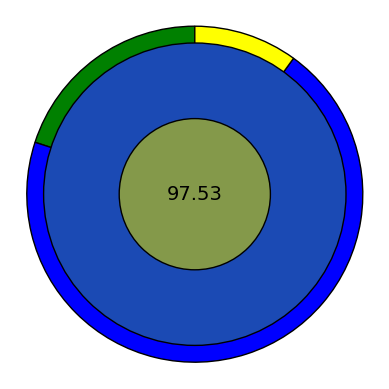

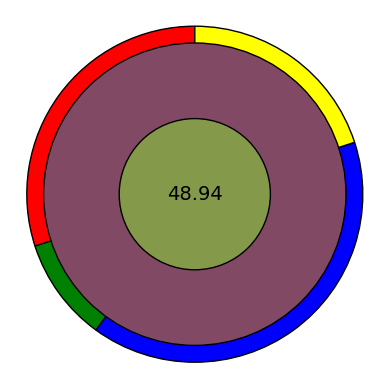

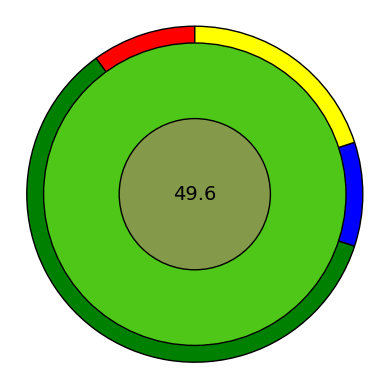

In [9]:
mixtures = [[0.0, 0.2, 0.7, 0.1],
            [0.3, 0.1, 0.4, 0.2],
            [0.1, 0.6, 0.1, 0.2]]

measurements = []
targets = []
scores = []

for color_mixture in mixtures:
    color_measurement = silicobot.mix_color(color_mixture)
    score = color_difference(color_measurement, silicobot.target_color)

    measurements.append(color_measurement)
    targets.append(silicobot.target_color)
    scores.append(score)

    visualize_rgb(mixture = color_mixture, rgb = color_measurement,
                  pump_controller = silicobot, score = score)


In [10]:
data = [mixtures, measurements, targets, scores]
data = [np.array(col) for col in data]

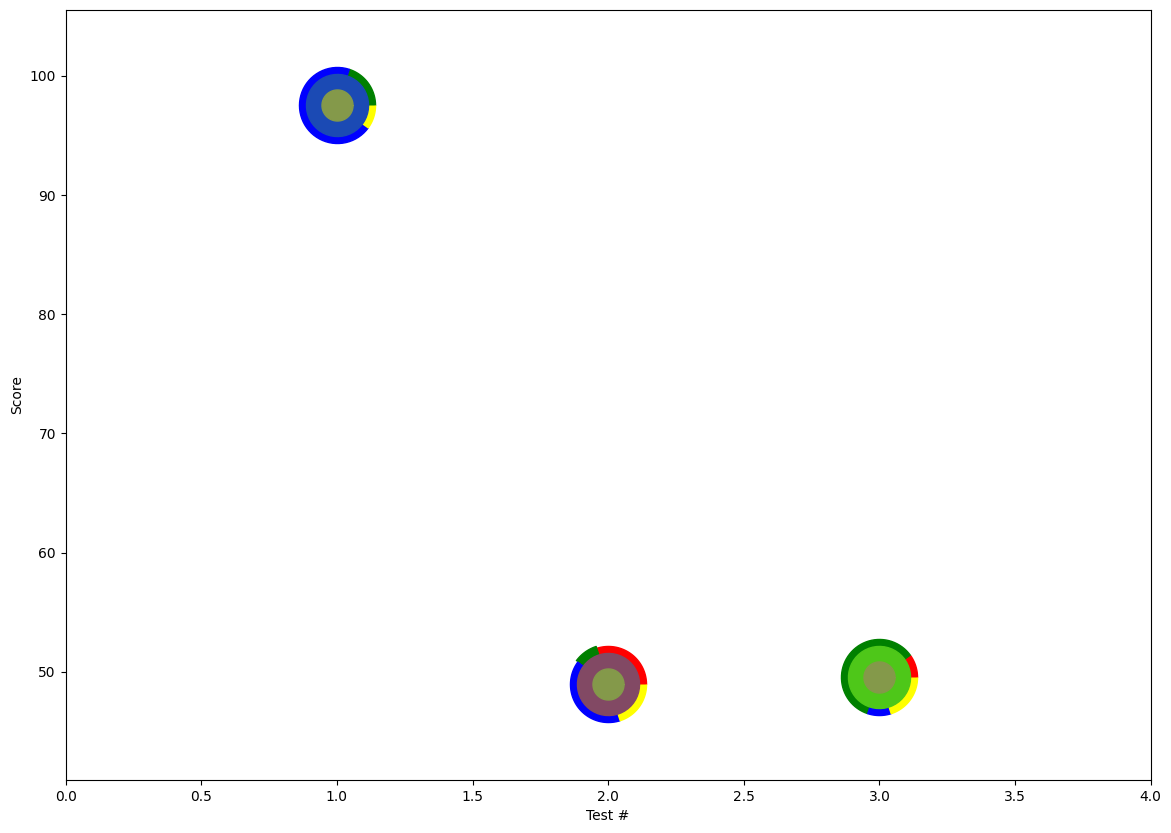

In [11]:
visualize_candidates(data)

# Scipy Optimization

In [12]:
import numpy as np

try:
    from scipy.optimize import minimize
except:
    !pip3 install scipy --user --upgrade
    from scipy.optimize import minimize

from IPython import display

### Setup

In [13]:
# Instantiate your SilicoPumpController
silicobot = SilicoPumpController(noise_std=3)  # Set an appropriate noise_std value

In [14]:
target_color_mixture = [0.4,0.4,0.1,0.1]
silicobot.change_target(target_color_mixture)

Silico target changed to [127.58854689 130.91759758  25.69825755]. Created by [0.4, 0.4, 0.1, 0.1].


array([127.58854689, 130.91759758,  25.69825755])

In [15]:
color_mixture = [0.3,0.3,0.3,0.1]
mixed_color = silicobot.mix_color(color_mixture)
print(mixed_color)

[ 92.69685208 102.77272864  83.79368474]


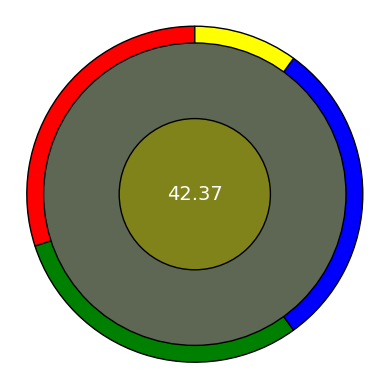

In [16]:
# Measure difference between mixed color and target color
score = color_difference(mixed_color, silicobot.target_color)

# Visualize the color mixing process
visualize_rgb(mixture=color_mixture, rgb=mixed_color, pump_controller=silicobot, score=score)

### Optimize

In [33]:
func_calls = [0]

# Data storage
mixtures = []
measurements = []
targets = []
scores = []

In [34]:
# Set initial guess
x0 = np.random.rand(4)
x0 /= np.sum(x0)  # Normalize to ensure the sum is 1
print(x0)

[0.39252764 0.19616198 0.04250636 0.36880402]


In [35]:
def find_color(color_mixture, func_calls = func_calls, n_func_calls = 11):
    
    mixed_color = silicobot.mix_color(color_mixture)
    score = color_difference(mixed_color, silicobot.target_color)

    mixtures.append(color_mixture)
    measurements.append(mixed_color)
    targets.append(silicobot.target_color)
    scores.append(score)

    data = [mixtures, measurements, targets, scores]
    data = [np.array(col) for col in data]

    func_calls[0] += 1
    if (func_calls[0] % n_func_calls == 0):
        plt.close('all')
        display.clear_output(wait=True)
        visualize_candidates(data)

    return score

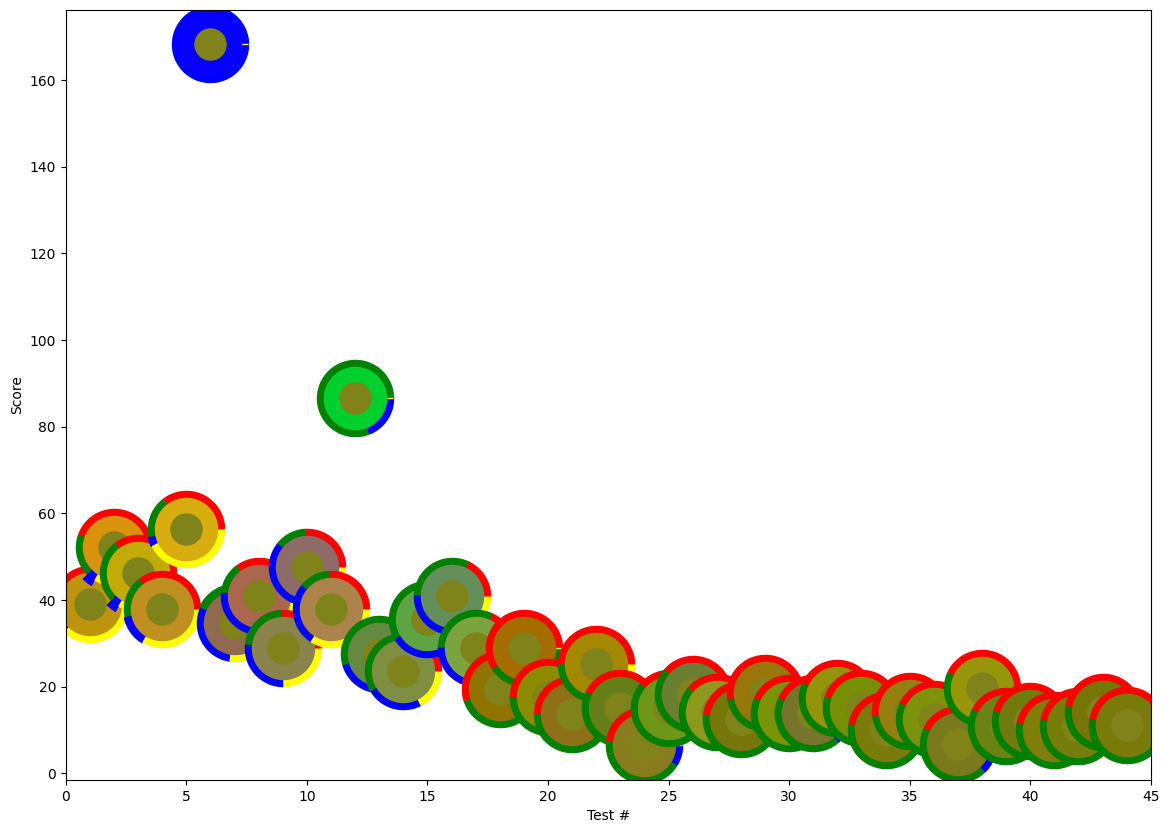


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 11.03218767659446
       x: [ 4.763e-01  4.851e-01  3.856e-02  6.647e-13]
     nit: 7
     jac: [ 4.480e+01  2.711e+01 -3.185e+01  9.727e+01]
    nfev: 49
    njev: 7


In [36]:
# Run the optimization with L-BFGS-B optimizer
res = minimize(find_color, x0, args=(func_calls), method='SLSQP',
               bounds=4 * [[0.0, 1.0]],
               constraints=({'type': 'eq', 'fun': lambda x:  1 - sum(x)}),
               options={'disp': False, 'eps': 0.1, 'maxiter': 50})
print()
print(res)

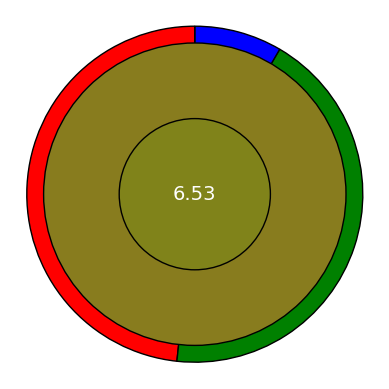

In [37]:
best_idx = np.argmin(scores)
visualize_rgb(mixtures[best_idx], measurements[best_idx], score=scores[best_idx], pump_controller=silicobot)

In [38]:
best_idx

23